In [1]:
from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["LIBGL_ALWAYS_SOFTWARE"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

In [2]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [3]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/localhome/volodin/local/usr/bin']

In [4]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

In [5]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [6]:
env = gym.make('CartPole-v0')

In [7]:
S_DIM = 4
ACTIONS = 2

In [8]:
# states
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
discounted_rewards = tf.placeholder(tf.float64, shape = (None,))

def fc_layer(x, n, activation = tf.nn.sigmoid):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [9]:
# layers
with tf.name_scope('layers'):
    z = states # state is an input
    z = fc_layer(z, 10)
    z# = fc_layer(z, 10)
    #z = fc_layer(z, 10)
    z = fc_layer(z, ACTIONS, activation = None)
    output = z

In [10]:
# softmax to make probability distribution
logits = tf.nn.softmax(output)

# predicted labels
labels = tf.argmax(logits, axis = 1)

In [11]:
params = tf.trainable_variables()

Want to optimize the sum of rewards:
$$
J(\theta)=\mathbb{E}_{\pi(\theta)}\sum\limits_{t=0}^\infty r_t
$$

Take the gradient and use log-likelihood trick:
$$
\nabla J(\theta)=\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\nabla_\theta \log \pi(a_t|s_t)=\nabla_\theta\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\log \pi(a_t|s_t)
$$

Therefore the task is equivalent to minimizing a loss of
$$
\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\log \pi(a_t|s_t)
$$

Which is estimated stochastically using episodes using the Policy Gradient Theorem: for one episode for $G_t=\sum\limits_{t'>t}r_t\gamma^{t'-t-1}$
$$
\nabla J(\theta)\approx \frac{1}{T}\sum\limits_{t=1}^T G_t\log\pi(a_t|s_t)
$$

In [12]:
# one-hot encoded actions
a_one_hot = tf.one_hot(actions, ACTIONS)

# taken logits
#logits_taken = tf.gather(logits, actions, axis = 1)
logits_taken = tf.boolean_mask(logits, a_one_hot)

# logarithm
log_logits = tf.log(logits_taken)

# logarithm of logits * reward
r_log_logits_sum = tf.reduce_sum(tf.multiply(discounted_rewards, log_logits))

# calculated loss
loss = -tf.reduce_sum(tf.multiply(log_logits, discounted_rewards))
#loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(a_one_hot, logits)) * tf.reduce_sum(rewards)

In [13]:
def sample_action(observation):
    """ Sample an action from the policy """
    
    p = sess.run(logits, feed_dict = {states: [observation]})[0]
    return np.random.choice(range(2), p = p)

In [14]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sar = []
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        sar.append((observation, act, reward))
        observation = observation_
    env.close()
    return sar

In [15]:
# learning rate for policy gradients
gamma_discount = 0.95

In [16]:
def discount(rewards):
    """ Discount and do cumulative sum """
    sum_so_far = 0.0
    rewards_so_far = []
    for r in rewards[::-1]:
        sum_so_far = sum_so_far * gamma_discount + r
        rewards_so_far.append(sum_so_far)
    return rewards_so_far[::-1]

In [17]:
opt = tf.train.AdamOptimizer(0.01).minimize(loss)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:
# one learning iteration
step = opt

In [19]:
def train_step():
    # obtaining rollout data
    S, A, R = list(zip(*get_rollout()))
    sess.run(step, feed_dict = {states: S, actions: A, discounted_rewards: discount(R)})
    return np.sum(R)

In [20]:
init = tf.global_variables_initializer()
sess.run(init)
r = []

In [21]:
for i in tqdm(range(500)):
    r += [train_step()]

100%|██████████| 500/500 [00:14<00:00, 24.00it/s]


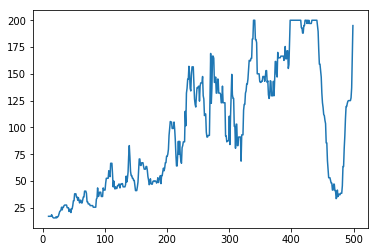

In [22]:
plt.plot(pd.DataFrame(r).rolling(10).median())

In [23]:
len(get_rollout())

200

In [24]:
env = env.unwrapped

In [ ]:
env = gym.wrappers.Monitor(env, './video')
get_rollout()

In [26]:
sess.run(params)

[array([[-0.18873484, -0.02347873, -0.09180877,  0.85437598,  0.73548765,
         -0.73257722, -0.62534989,  0.11622637,  0.20281138, -0.18195212],
        [ 0.59836861, -0.5312947 ,  0.40047014, -0.21417986, -0.07715603,
          0.31041685, -0.40055877, -0.73640866, -0.43643387,  0.42187376],
        [ 2.75277087, -2.28036003,  2.64911943, -2.98041001,  1.98106239,
          1.78692565, -2.19191594, -2.3974329 , -2.14004163,  2.22988617],
        [ 1.74699108, -1.05876661,  1.6915184 , -1.71513391,  2.09871922,
          2.09407334, -1.69480904, -1.17094075, -2.48597429,  2.29102605]]),
 array([-0.07335326, -0.08722787, -0.07997816, -0.15610739, -0.15218183,
        -0.01671254, -0.06472923, -0.10231432, -0.01664884, -0.13685326]),
 array([[-0.57068403,  0.57549599],
        [ 0.33537788, -0.67760173],
        [-0.45219608,  0.58277224],
        [ 0.27618997, -0.47491201],
        [-0.51973262,  0.21592388],
        [-1.157384  ,  0.60184666],
        [ 0.86199904, -0.71488893],
  

In [27]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

'./cartpole-h1.ckpt'

In [28]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-h1.ckpt
